In [1]:
# Importing all libraries
import numpy
from matplotlib import pyplot
from time import time

In [2]:
from codes.grids import regular_grid
from codes.prism import prism_tf
from codes.auxiliars import addnoise
from codes.statistical import analysis

In [3]:
# Defines number of points
nx, ny = 50, 50
# Define the area
area = (-2000., 2000., -2000., 2000.)
shape = (nx, ny)
# Creates the grid
xobs, yobs, zobs = regular_grid(area, shape, -200.)

In [4]:
# Define the elements of the prims for gravity and magnetic computation
model1 = (-200., 200., -500., 500., 100., 300., 1.28)
# Directions
inc, dec = 55., -44. # field
incs, decs = 3., 2. # source

In [5]:
# Computes the total field anomaly
tf = prism_tf(xobs, yobs, zobs, model1, inc, dec, incs, decs)

In [6]:
_ = analysis(tf, 'nT')

Minimum:    -65.8569 nT
Maximum:    52.2536 nT
Mean value: -0.2512 nT
Variation:  118.1105 nT


In [7]:
# Adding noise
tf = addnoise(tf, 4., 0.1)

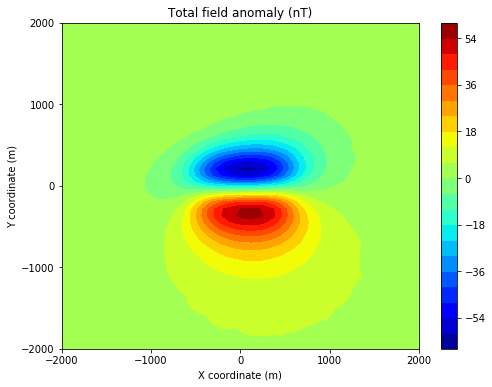

In [8]:
# Plotting the result
pyplot.figure(figsize=(8, 6))
pyplot.contourf(yobs.reshape(shape), xobs.reshape(shape), tf.reshape(shape), 
                20, cmap = pyplot.cm.jet)
pyplot.title('Total field anomaly (nT)')
pyplot.xlabel('X coordinate (m)')
pyplot.ylabel('Y coordinate (m)')
pyplot.xticks(numpy.linspace(yobs.min(), yobs.max(), 5))
pyplot.yticks(numpy.linspace(xobs.min(), xobs.max(), 5))
pyplot.colorbar()
pyplot.show()

In [9]:
from codes.equivalentlayer import layer, mat_mag_tfa

In [10]:
# Layer informations
area_layer = (-2000., 2000., -2000., 2000.)
shape_layer = (15, 15)
level = 500.

In [11]:
# Create the layer
eqlayer = layer(area_layer, shape_layer, level)

In [12]:
data = [xobs, yobs, zobs, tf]

In [13]:
def rtp_layer(datasets, datashape, layermodel, layershape, incf, decf, inceql = None, deceql = None):
    '''
    It returns the reduce to Pole data by using the equivalent layer technique. This functions 
    must receives all data as a list with all positions for x, y and z, and also the potential 
    data. It receives the shape of the data, the model as an equivalent layer and the values of
    inclination and declination as well, for both field and depth sources.    
    
    Inputs:
    datasets - numpy list - x, y and z positions and total field data
    datashape - tuple - shape of the input data
    layermodel - list - values for created equivalent layer
    layershape - tuple - shape of the equivalent layer
    incf - float - inclination of the geomagnetic field
    decf - float - declination of the geomagnetic field
    inceql - float - inclination of all depth sources
    deceql - float - declination of all depth sources
    
    Output:
    rtp - numpy array - reduce to Pole data
    
    '''
    
    # Verify the depth of the equivalent layer
    if level <= 0.:
        raise ValueError('Layer depth must be a positive value!')
    
    # Define the type of magnetization
    if inceql == None or deceql == None:
        inceql = incf
        deceql = decf
        
    # Datasets = [xobs, yobs, zobs, totalfield]
    xp = datasets[0]
    yp = datasets[1]
    zp = datasets[2]
    tf = datasets[3]
    
    # Define the number of observations and depth sources
    N = datashape[0]*datashape[1]
    M = layershape[0]*layershape[1]
    
    # Computes the sensitivity matrix
    matA = mat_mag_tfa(xp, yp, zp, layermodel, incf, decf, inceql, deceql)
    
    # Case1: Overdetermined - Number of observations are greater or equal than the number of depth sources
    if N >= M: 
        mu = 1.e-6
        I = numpy.identity(M)
        trace = numpy.trace(matA.T.dot(matA))/M
        vec = numpy.linalg.solve(numpy.dot(matA.T, matA) + mu*trace*I, numpy.dot(matA.T, tf))
    # Case2: Underterminated - Number of observations are less than the number of depth sources
    else:
        mu = 1.e-6
        I = numpy.identity(N)
        trace = numpy.trace(matA.T.dot(matA))/N
        aux = numpy.linalg.solve(numpy.dot(matA, matA.T) + mu*trace*I, tf)
        vec = numpy.dot(matA.T, aux)
        
    # Calculates the predicted total field anomaly data
    tf_pred = numpy.dot(matA, vec)
    
    # Create the new matrix for reduction to Pole
    mat_rtp = mat_mag_tfa(xp, yp, zp, layermodel, 90., 0., 90., 0.)
    # Calculates the reduction to Pole
    rtp = numpy.dot(mat_rtp, vec)    
    return rtp.reshape(datashape)

In [14]:
# Importing filtering functions
from codes.filtering import reduction
from codes.derivative import totalgrad, zderiv
# Importing the correlation function
from codes.statistical import cccoef

In [16]:
# Create the grid
# for the fourier trans:
I1 = numpy.linspace(-90.0, -10.0, 80)
I2 = -I1 
D1 = numpy.linspace(-180.0, 180.0, 361)

# for the layer:
I3 = numpy.linspace(-10.0,10.0, 5)
D3 = numpy.linspace(-180.0, 180.0, 37 )

shape_IncDec = (100,100)
inclination, declination = regular_grid((-90., 91., -180., 181.),shape_IncDec ) # (181, 361))
print declination.shape

(10000,)


In [ ]:
#CC = numpy.zeros((I.size, D.size))
#CC = numpy.zeros(I.size*D.size)

In [ ]:
ti = time()
CC = []
Xobs = xobs.reshape(shape)
Yobs = yobs.reshape(shape)
Tf = tf.reshape(shape)

for i in I:
    for j in D:
        rtp = reduction(Xobs, Yobs, Tf, inc, dec, i, j)
        tga = totalgrad(Xobs, Yobs, rtp)
        vga = zderiv(Xobs, Yobs, rtp)
      
 #       rtp = reduction(xobs.reshape(shape), yobs.reshape(shape), tf.reshape(shape), inc, dec, i, j)
  #      tga = totalgrad(xobs.reshape(shape), yobs.reshape(shape), rtp)
   #     vga = zderiv(xobs.reshape(shape), yobs.reshape(shape), rtp)
        CC.append(cccoef(tga, vga)) 
        
CC = numpy.array(CC)
ttf = time()
print 'time in seconds = ', ttf - ti

In [ ]:
# check time process:
ti = time()
CC = []
Xobs = xobs.reshape(shape)
Yobs = yobs.reshape(shape)
Tf = tf.reshape(shape)
for i in I:
    for j in D:
        if i >= -5. or i <= 5.:
            tf_rtp = rtp_layer(data, shape, eqlayer, shape_layer, inc, dec, i, j)
            tga = totalgrad(Xobs, Yobs, tf_rtp)
            vga = zderiv(Xobs, Yobs, tf_rtp)
            CC.append(cccoef(tga, vga))
        else:
            rtp = reduction(Xobs, Yobs, Tf, inc, dec, i, j)
            tga = totalgrad(Xobs, Yobs, rtp)
            vga = zderiv(Xobs, Yobs, rtp)
            CC.append(cccoef(tga, vga))
ttf = time()
print 'time in seconds = ', ttf - ti

In [ ]:
# Plotting the correlation results
pyplot.figure(figsize=(12, 8))
fig1 = pyplot.contour(declination.reshape(shape_IncDec), inclination.reshape(shape_IncDec), 
                      CC.reshape(shape_IncDec), 10, colors = 'k', linestyle = 'solid', linewidths = 1)
pyplot.contourf(declination.reshape(shape_IncDec), inclination.reshape(shape_IncDec), CC.reshape(shape_IncDec), 
                10, cmap = pyplot.cm.gray)

pyplot.plot(decs, incs, 'r*', markersize = 8, label = 'Maximum coef')
pyplot.clabel(fig1, fontsize = 8)
pyplot.rcParams['contour.negative_linestyle'] = 'solid'
pyplot.title('Correlation coeficients', fontsize = 16)
pyplot.xlabel('Declination (degrees)', fontsize = 14)
pyplot.ylabel('Inclination (degrees)', fontsize = 14)
pyplot.xticks(numpy.arange(D.min(), D.max(), 45), fontsize = 14)
pyplot.yticks(numpy.arange(I.min(), I.max(), 20), fontsize = 14)
pyplot.legend(loc = 'upper center', fontsize = 'large')
pyplot.colorbar()
pyplot.show()

In [ ]:
# Analysing the positive coefficients
_ = analysis(coef, 'no unit')